In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>")) #$\color{red}{\text{ciao}}$

# Python para Finanzas y Ciencia de Datos
____


1. Statistics Concepts
2. Portfolio Optimization
3. Principal Component Analysis (PCA)
4. Value-at-Risk (VaR)
____

In [2]:
# IMPORTAMOS LAS LIBRERÍAS QUE VAMOS A USAR A LO LARGO DEL MÓDULO.
import numpy as np
import pandas as pd
import pandas_datareader.data as reader

from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timedelta
from numpy.random import multivariate_normal
import yfinance as yf

import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci
from scipy.stats import gaussian_kde

import statsmodels.api as sm

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

import seaborn as sns

#import functions as f 

import random
random.seed(1000)


# Principal Component Analysis (PCA)

----

The main idea behind PCA is that a high dimensional system can be approximated to a reasonable degree of accuracy by a system with a smaller number of dimensions by exploiting correlations between the system variables.
PCA is a particularly powerfull tool in finance, since it allows to reduce the sources of uncertity of a portfolio consisting in multiple assets onto a fewer number of factors that explains the underlying structure of those assets.


## Mathematics behind PCA

Principal components are unobserved variables defined as linear combinations of the observed random variables. There is as much PC as observed variables.

$$ Y_1 = a_1'X = a_{11}X_1 + a_{12}X_2 + ... + a_{1n}Xn $$

$$ Y_2 = a_2'X = a_{21}X_1 + a_{22}X_2 + ... + a_{2n}Xn $$
$$ . $$
$$ . $$
$$ Y_n = a_n'X = a_{n1}X_1 + a_{n2}X_2 + ... + a_{nn}Xn$$

By these linear combination we are rotating the original system into a new cordinate system which represents the directions of the maximum variability and provides a more parsimonious description of the covariance structure. 


Let the random vector $X_{Txn} = [X_1 , X_2, . . . ,X_n ]$ have a covariance matrix $\Sigma_x$. Since $\Sigma_x$ is non-negative definite, it has a spectral descomposition

$$ \Sigma_x = P \Lambda P' $$

where P is an orthonormal matrix consisting of the n eigenvectors and $\Lambda$ is a diagonal matrix consisting of the n eigenvalues.
Let $(\lambda_1,e_1), . . , (\lambda_n,e_n)$ be the eigenvalue-eigenvector pairs of $\Sigma_x$, where $\lambda_1 \geq \lambda_2 \geq ...\geq \lambda_n \geq 0$. Then, the variance of each new variable can be expressed as

$$ Var(Y_i ) = a_{i}' \Sigma_x a_i \ \forall \ i = 1, 2, ..., n $$

$$Cov(Y_i, Y_k ) = a_{i}' \Sigma_x a_k \ \forall \ i = 1, 2, ..., n $$

PCs are defined as those uncorrelated linear combinations $Y_1, Y_2, . .  ,Y_n$  (i.e.: $Cov(Y_i, Y_k )= 0$)  whose variances in equation are as large as possible. Since the variance of the unobserved variables could easily be increased by increasing $a_i$, we impose the restriction of **unit lenght** to the vector of coefficients $a_i$: $ a_i'a_i = \sum a_i^2 = 1$.

The optimization problem can be expressed in n steps:

For the first principal component:
$$ max Var(Y_1) = a_{i}' \Sigma_x a_i$$

$$s.t. a_i'a_i = 1$$

For the i-th principal component:
$$ max Var(Y_i) = a_{i}' \Sigma_x a_i$$

$$s.t. a_i'a_i = 1 \\
Cov(a_i'X, a_k'X)= 0 \ \  \forall \ k < i$$

The i-th principal component of X is $Y_i = e_i'X $. Consecuently:


$$ Var(Y_i) = e_i'\Sigma_xe_i = \lambda_i$$
$$ Cov(Y_i, Y_j) = e_i'\Sigma_xe_j = 0$$

In addition, the proportion of total variance in X explained by the i-th PC is:

$$ \dfrac{\lambda_i}{\lambda_1+ ... + \lambda_n} $$

Since we are in the world of variance and covariance, which are measures of central tendency, we are really talking about deviation from the mean. Intuitively, PCs represent ways in which the observed random variables can deviate from their mean levels.

### In a nutshell:
Principal Component Analysis (PCA) decomposes the data into many vectors called principal components that essentially “summarise” the given data. More specifically, these summaries are linear combinations of the input features that try to explain as much variance in the data as possible. By convention, these principal components are ordered by the amount of variance they can explain, with the first principal component explaining most of the data.

In [3]:
# We import the data again

tickers_funds =['IAU','TLH','LQD','HYG','^GSPC','EFA','EEM','VNQ','DX-Y.NYB','EURUSD=X']

data = pd.DataFrame(columns=tickers_funds)

for ticker in tickers_funds:
    data[ticker] = yf.download(ticker, period='10y')['Adj Close']
    

tickers_labels = ['Gold','iShares US Treas 10y-20y','iShares IG Corp',
                  'iShares HY Corp','S&P 500','iShares MSCI EAFE','iShares MSCI EM',
                  'Vanguard Real Estate Index', 'US Dollar/USDX - Index','EURUSD=X']

data.columns = tickers_labels
data = data.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
data.head()

,Gold,iShares US Treas 10y-20y,iShares IG Corp,iShares HY Corp,S&P 500,iShares MSCI EAFE,iShares MSCI EM,Vanguard Real Estate Index,US Dollar/USDX - Index,EURUSD=X
Date,,,,,,,,,,
2012-06-28,30.320000,112.121597,85.402298,53.649532,1329.040039,35.802429,30.490623,43.111145,82.669998,1.247349
2012-06-29,31.120001,111.105164,85.380531,54.159725,1362.160034,37.094349,31.841427,44.212570,81.650002,1.244091
2012-07-02,31.120001,111.947479,85.833633,54.218182,1365.510010,37.339359,31.841427,44.699089,81.870003,1.265518
2012-07-03,31.600000,111.409836,85.906502,54.415077,1374.020020,37.680908,32.476135,44.962624,81.779999,1.258178
2012-07-05,31.260000,111.694916,86.125053,54.421062,1367.579956,37.057228,32.134369,44.685574,82.809998,1.251627


In [5]:
noa = len(tickers_labels)
rets = data.pct_change().round(4).dropna()
rets.head()

,Gold,iShares US Treas 10y-20y,iShares IG Corp,iShares HY Corp,S&P 500,iShares MSCI EAFE,iShares MSCI EM,Vanguard Real Estate Index,US Dollar/USDX - Index,EURUSD=X
Date,,,,,,,,,,
2012-06-29,0.0264,-0.0091,-0.0003,0.0095,0.0249,0.0361,0.0443,0.0255,-0.0123,-0.0026
2012-07-02,0.0000,0.0076,0.0053,0.0011,0.0025,0.0066,0.0000,0.0110,0.0027,0.0172
2012-07-03,0.0154,-0.0048,0.0008,0.0036,0.0062,0.0091,0.0199,0.0059,-0.0011,-0.0058
2012-07-05,-0.0108,0.0026,0.0025,0.0001,-0.0047,-0.0166,-0.0105,-0.0062,0.0126,-0.0052
2012-07-06,-0.0134,0.0054,0.0025,-0.0013,-0.0094,-0.0094,-0.0182,0.0024,0.0058,-0.0100


https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

In [6]:
from sklearn.decomposition import PCA

In [7]:
pca = PCA(n_components = noa) #We can extract as many PC as observed variables we have

In [8]:
principal = pd.DataFrame(pca.fit_transform(rets), # Fits the model and apply the dimensionality reduction on rets.
                         
                         columns = ['PC'+str(i) for i in range(1, noa+1)], # Columns = PC1, .., PC10
                         index = rets.index) 
principal.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Date,,,,,,,,,,
2012-06-29,0.034012,-0.063261,-0.011939,-0.000999,0.002046,-0.003715,-0.011922,-0.001263,-0.001567,0.000664
2012-07-02,0.000915,-0.008612,0.010122,-0.005753,-0.016237,0.001951,0.001526,0.007022,0.004079,-0.000145
2012-07-03,0.017552,-0.019296,-0.008204,-0.001442,0.005810,-0.005551,-0.000856,-0.002947,0.001270,0.001343
2012-07-05,-0.013617,0.018242,0.005287,0.000540,0.006020,-0.002193,0.013711,-0.002358,0.002647,-0.000062
2012-07-06,-0.015886,0.017351,0.014605,0.000228,0.010090,0.001039,0.000991,0.000458,0.004250,-0.000981


In [9]:
loadings = pd.DataFrame(pca.components_.T,  # Gives us the matrix of loadings: how each PC affects X
                        columns = ['PC'+str(i) for i in range(1, noa+1)],
                        index = rets.columns)

In [10]:
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
Gold,0.991840,0.116808,0.000605,0.047083,-0.001303,-0.008328,0.017184,0.002612,0.004382,0.000409
iShares US Treas 10y-20y,0.021943,0.079100,0.245396,-0.685903,0.069428,0.156416,0.135664,0.432520,-0.169437,-0.446213
iShares IG Corp,0.028539,-0.053318,0.220761,-0.493058,0.008117,0.289737,0.167984,-0.259870,0.213447,0.692226
iShares HY Corp,0.025386,-0.186538,0.072077,-0.068201,-0.069508,0.222760,0.132470,-0.691269,0.297093,-0.562667
S&P 500,0.040247,-0.467189,0.013187,0.273692,0.010648,0.434467,0.447800,0.045202,-0.557631,0.051366
iShares MSCI EAFE,0.060718,-0.459864,-0.202998,0.042074,0.007276,0.460762,-0.433264,0.378294,0.444966,-0.026205
iShares MSCI EM,0.076055,-0.544278,-0.503689,-0.376716,0.036224,-0.527785,0.126798,-0.058644,-0.046081,0.029156
Vanguard Real Estate Index,0.048217,-0.464394,0.767830,0.116871,0.000054,-0.380281,-0.174600,0.047913,0.036284,0.008953
US Dollar/USDX - Index,-0.029954,0.027630,0.034590,0.214551,0.102452,-0.130117,0.703010,0.322873,0.569654,-0.026630
EURUSD=X,-0.000751,-0.007439,-0.002202,-0.035772,-0.989094,-0.027048,0.080656,0.111370,0.023564,0.012570


In [11]:
var = pca.explained_variance_ratio_  # Percentage of variance explained by each of the selected components

var_factors = pd.DataFrame(columns = ['PC', 'Variance'])

var_factors['PC'] = ['PC'+str(i) for i in range(1, noa+1)]
var_factors['Variance']= [var[i].round(4) for i in range(len(var))]

### Explained variance

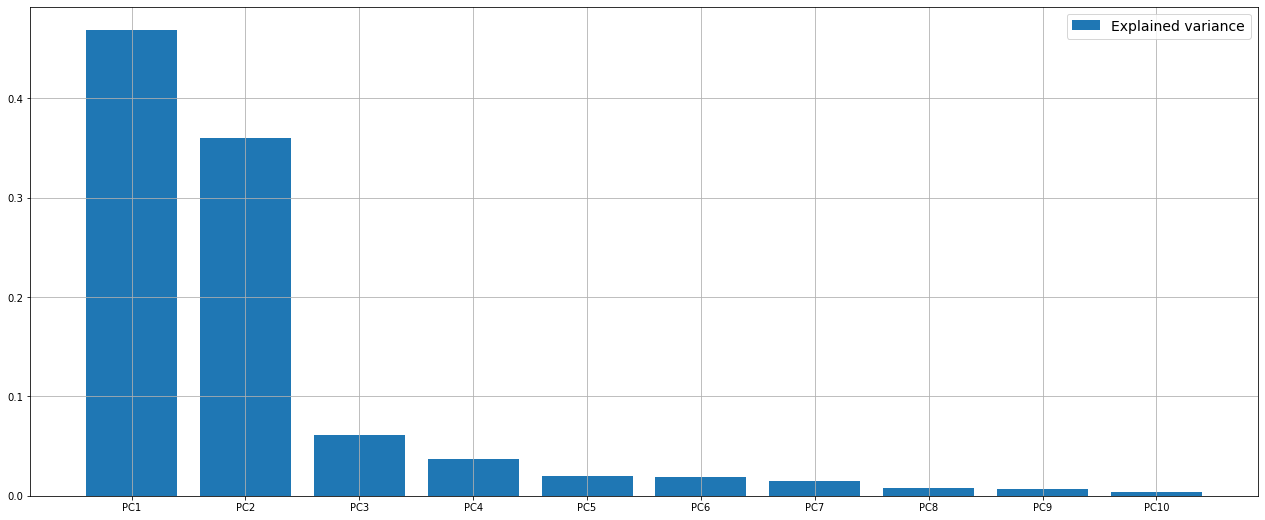

In [15]:
fig = plt.figure(figsize = (22,9))
plt.bar(var_factors['PC'], var_factors['Variance'], label = 'Explained variance')
plt.legend(loc = 'upper right', fontsize = 14)
plt.grid(True)

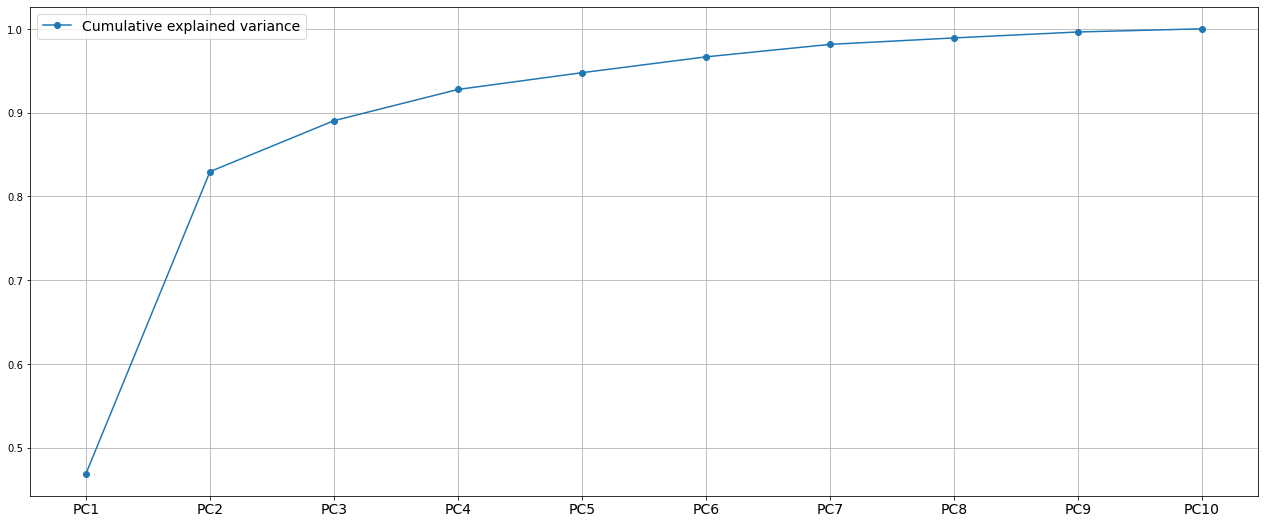

In [16]:
fig = plt.figure(figsize = (22,9))
plt.plot(var_factors['PC'], np.cumsum(var_factors['Variance']), label = 'Cumulative explained variance', marker = 'o')
plt.legend(loc = 'upper left', fontsize = 14)
plt.xticks(size = 14)
plt.grid(True)

Note that we can explain more than 90% of the variability of the porfolio with only 5 principal components. Let's only keep only 5 PC.

In [17]:
pca = PCA(5)

principal = pd.DataFrame(pca.fit_transform(rets),
                         columns = ['PC'+str(i) for i in range(1, 6)],
                         index = rets.index)

loadings = pd.DataFrame(pca.components_.T, 
                        columns = ['PC'+str(i) for i in range(1, 6)],
                        index = rets.columns)

principal = principal*(-1)  #
loadings = loadings*(-1)    #

In [18]:
loadings

,PC1,PC2,PC3,PC4,PC5
Gold,-0.991840,-0.116808,-0.000605,-0.047083,0.001303
iShares US Treas 10y-20y,-0.021943,-0.079100,-0.245396,0.685903,-0.069428
iShares IG Corp,-0.028539,0.053318,-0.220761,0.493058,-0.008117
iShares HY Corp,-0.025386,0.186538,-0.072077,0.068201,0.069508
S&P 500,-0.040247,0.467189,-0.013187,-0.273692,-0.010648
iShares MSCI EAFE,-0.060718,0.459864,0.202998,-0.042074,-0.007276
iShares MSCI EM,-0.076055,0.544278,0.503689,0.376716,-0.036224
Vanguard Real Estate Index,-0.048217,0.464394,-0.767830,-0.116871,-0.000054
US Dollar/USDX - Index,0.029954,-0.027630,-0.034590,-0.214551,-0.102452
EURUSD=X,0.000751,0.007439,0.002202,0.035772,0.989094


### What is a PC? How does it look like?

As we said, a principal component aims to reduce the sources of variability in a data set. 

Think in our specific case of 10 asset. If we plot all their daily returns (only for 120 days, for illustration purposes), we get the following mess of a chart. 

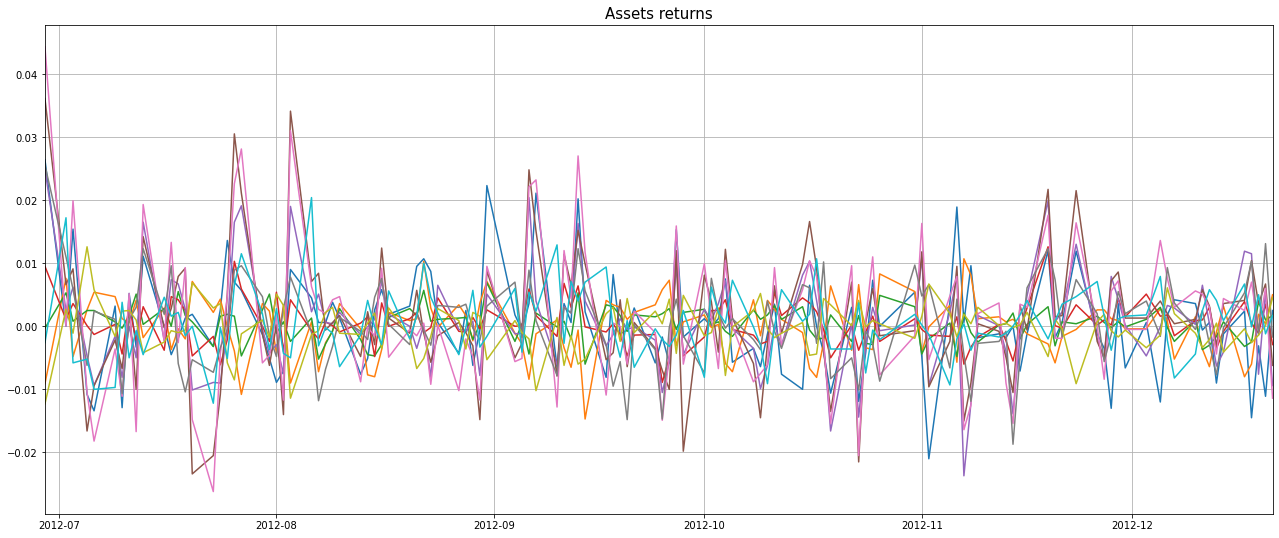

In [19]:
fig = plt.figure(figsize = (22,9))

plt.plot(rets[:120])
plt.autoscale(axis = 'x', tight = True)
plt.title('Assets returns', fontsize = 15)
plt.grid(True)

Every asset is sort of doing its own thing and there is not much to extract from this chart besides that daily stock returns are noisy and volatile.

Let's see what our first PC look like.

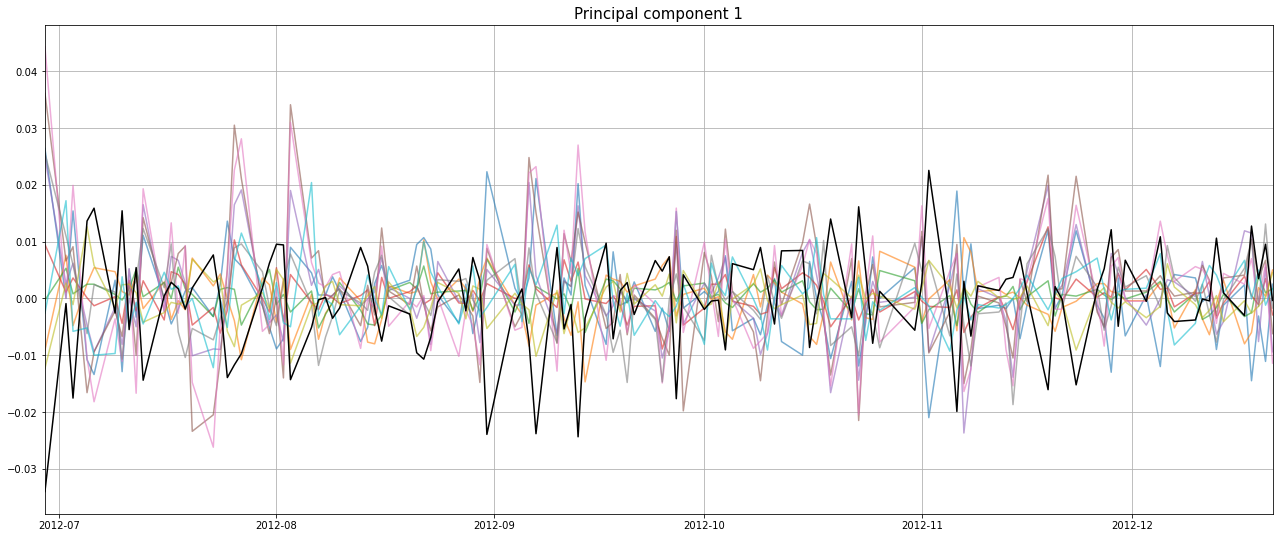

In [20]:
fig = plt.figure(figsize = (22,9))

plt.plot(rets[:120], alpha = 0.6)
plt.plot(principal['PC1'][:120], color = 'black')
plt.autoscale(axis = 'x', tight = True)
plt.title('Principal component 1', fontsize = 15)
plt.grid(True)

Note how the first PC seems to follow the most important movements in the data. That is exactly how PC1 is found: by looking for the strongest underlying trend in the set

### And the other PCs?

- The second PC corresponds to second strongest underlying trend in the set that also happens to be uncorrelated with component 1.
- The third PC reproduces the third strongest underlying trend in the set that also happens to be uncorrelated with both components 1 and 2
- And so on...

### Factor loadings

A factor loading is the sensivility of the observed variable (in this case, the asset returns) to a certain factor. Factor loadings are useful to understand and interpret the principal components.

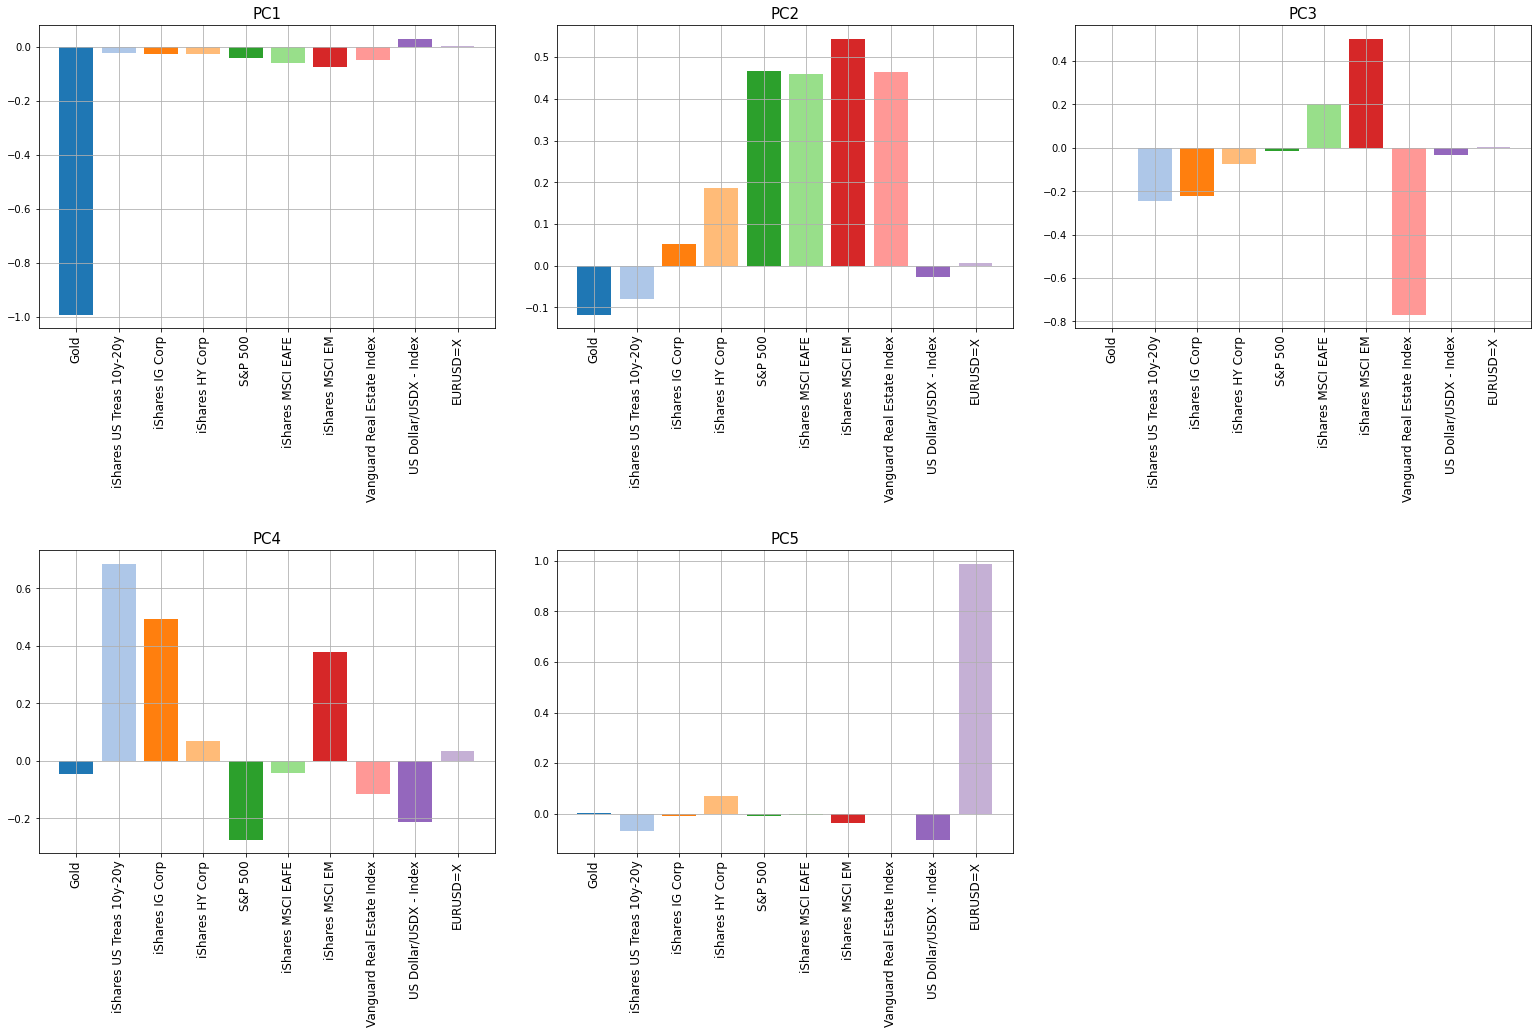

In [21]:
fig = plt.figure(figsize = (22,15))

for i in range(len(loadings.columns)):
    plt.subplot(2,3,i+1)
    plt.bar(loadings.index, loadings['PC'+str(i+1)], color = sns.color_palette(palette = 'tab20'))
    plt.title(loadings.columns.values[i], size = 15)
    plt.xticks(rotation = 90, size = 12)
    plt.grid(True)

plt.tight_layout(pad=3.0)